In [1]:
!pip install segment-anything opencv-python matplotlib onnxruntime onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00


In [15]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from segment_anything import sam_model_registry, SamPredictor
import random

In [3]:
def load_tiff_file(file_path):
    images = tiff.imread(file_path)
    return images

def select_and_show_image(images):
    n = len(images)
    index = int(input(f"Enter image index (1 to {n}): ")) - 1
    if 0 <= index < n:
        plt.imshow(images[index], cmap='gray')
        plt.title(f'Image index: {index + 1}')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.axis('on')
        plt.show()
        time.sleep(3)
        return index
    else:
        print("Invalid index.")
        return None


In [4]:
def get_manual_coordinates(index):
    x = int(input("Enter x coordinate: "))
    y = int(input("Enter y coordinate: "))
    coords = {'image_index': index + 1, 'x': x, 'y': y}
    return coords

In [5]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

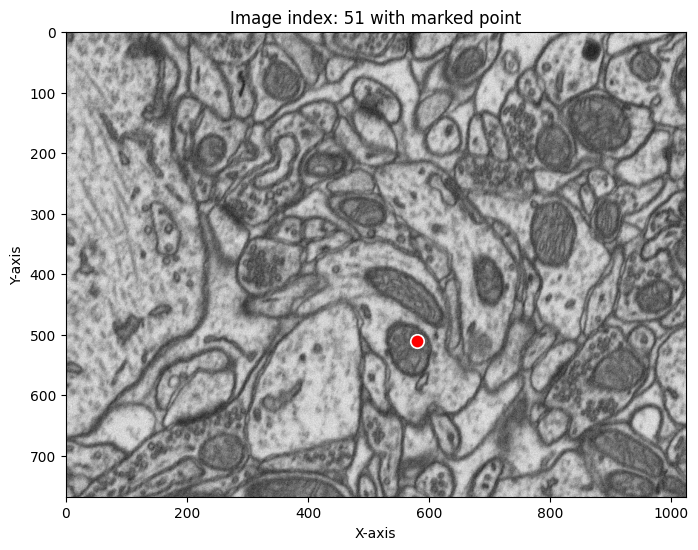

In [ ]:
file_path = "/content/drive/MyDrive/Mitochondria-Data/Data/train/training.tif"
images = load_tiff_file(file_path)

# index = select_and_show_image(images)
index = 50
if index is not None:
    # coordinates = get_manual_coordinates(index)
    coordinates = {'image_index': index , 'x': 580, 'y': 510}
    input_point = np.array([[coordinates['x'], coordinates['y']]])
    input_label = np.array([1])
    the_img = images[index]
    plt.figure(figsize=(8, 8))
    plt.imshow(the_img, cmap='gray')
    show_points(input_point, input_label, plt.gca())
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(f"Image index: {index + 1} with marked point")
    plt.axis('on')
    plt.show()

In [ ]:
the_img = cv2.cvtColor(the_img, cv2.COLOR_BGR2RGB)

In [7]:
sam_checkpoint = '/content/drive/MyDrive/Mitochondria-Data/sam-predictor/sam_vit_h_4b8939.pth'
device = 'cuda'
model_type = 'default'

In [9]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

sam.to(device=device)
predictor = SamPredictor(sam)




In [ ]:
predictor.set_image(the_img)

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True)

In [ ]:
masks.shape  # Number of masks, H, W

(3, 768, 1024)

In [ ]:
# for i, (mask, score) in enumerate(zip(masks, scores)):
#     plt.figure(figsize=(10,10))
#     plt.imshow(the_img)
#     show_mask(mask, plt.gca())
#     show_points(input_point, input_label, plt.gca())
#     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
#     plt.axis('off')
#     plt.show()

best_index = np.argmax(scores)

plt.figure(figsize=(10, 10))
plt.imshow(the_img)
show_mask(masks[best_index], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Best Mask, Score: {scores[best_index]:.3f}", fontsize=18)
plt.axis('off')
plt.show()


# Predict With centroids

In [10]:
# Initialize a dictionary to store centroids
centroids_dict = {}

# Read centroids from txt file
with open('/content/drive/MyDrive/Mitochondria-Data/Data/txt/test_centroids.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if line.strip():  # Check if the line is not empty
            parts = line.strip().split(": ")
            if len(parts) == 2:  # Ensure the line has the correct format
                image_num = int(parts[0])
                centroids = eval(parts[1])
                centroids_dict[image_num] = centroids

print("Centroids loaded successfully from centroids.txt!")
print(centroids_dict)

Centroids loaded successfully from centroids.txt!
{0: [(60, 24), (77, 30), (126, 37), (22, 43), (29, 60), (102, 54), (16, 62), (60, 61), (91, 66), (122, 81), (84, 99), (15, 111), (54, 114), (64, 124), (115, 125), (85, 125)], 1: [(80, 27), (60, 24), (126, 37), (21, 43), (23, 61), (102, 54), (60, 62), (91, 66), (52, 73), (121, 81), (84, 99), (15, 113), (54, 114), (64, 124), (85, 125), (115, 125)], 2: [(79, 27), (126, 37), (20, 44), (23, 61), (102, 54), (60, 62), (91, 66), (53, 74), (121, 81), (84, 99), (15, 112), (54, 114), (64, 124), (114, 125)], 3: [(79, 27), (126, 38), (21, 44), (23, 61), (102, 54), (60, 62), (91, 66), (79, 71), (122, 81), (84, 99), (14, 114), (53, 114), (64, 124), (114, 125), (84, 126)], 4: [(79, 27), (126, 38), (21, 44), (51, 45), (24, 60), (102, 54), (60, 62), (90, 66), (120, 73), (122, 81), (84, 99), (15, 111), (53, 114), (13, 122), (63, 124), (85, 126), (115, 126)], 5: [(80, 27), (126, 38), (20, 44), (51, 45), (29, 59), (15, 62), (60, 62), (90, 65), (120, 73), (1

In [11]:
# Load the original images
images_path = '/content/drive/MyDrive/Mitochondria-Data/Data/test/testing.tif'
images = tiff.imread(images_path)
original_size = images.shape[1:3]  # Get original size of images (height, width)
print(f"Loaded {len(images)} images from {images_path}")

# Ensure images are in (height, width, channels) format
if images.ndim == 3:  # If images are (num_images, height, width)
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    images = np.repeat(images, 3, axis=-1)  # Repeat channels to convert to RGB format

# Assuming the original model used 128x128 images
model_image_size = (128, 128)

Loaded 165 images from /content/drive/MyDrive/Mitochondria-Data/Data/test/testing.tif


In [12]:
# Function to adjust centroids according to original image size
def adjust_centroids(centroids, original_size, model_image_size):
    h, w = original_size
    scale_x = w / model_image_size[1]
    scale_y = h / model_image_size[0]
    adjusted_centroids = [(int(x * scale_x), int(y * scale_y)) for x, y in centroids]
    return adjusted_centroids

adjusted_centroids_dict = {i: adjust_centroids(centroids, original_size, model_image_size) for i, centroids in centroids_dict.items()}
print("Centroids adjusted successfully!")

Centroids adjusted successfully!


In [13]:
def dice_coefficient(predicted_mask, true_mask):
    intersection = np.sum(predicted_mask * true_mask)
    sum_pred_true = np.sum(predicted_mask) + np.sum(true_mask)
    if sum_pred_true == 0:
        return 1.0  # If both are empty, it's a perfect match
    return (2.0 * intersection) / sum_pred_true

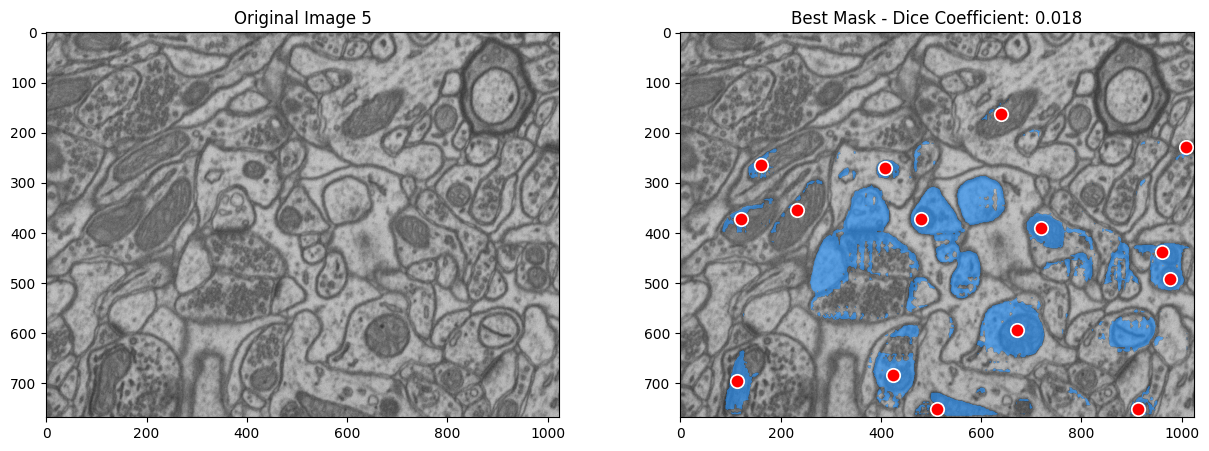

Processed Image 5, Best Dice Coefficient: 0.018


In [19]:
random_index = random.choice(list(adjusted_centroids_dict.keys()))

# Load the image and corresponding centroids
image = images[random_index]
input_points = np.array(adjusted_centroids_dict[random_index])
input_labels = np.ones(len(input_points))

# Set the image for SAM predictor
predictor.set_image(image)

# Predict masks using SAM
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True
)

# Assuming true_mask is available for the selected image
true_mask = np.zeros_like(masks[0], dtype=np.uint8)
for point in input_points:
    cv2.circle(true_mask, (point[0], point[1]), radius=5, color=1, thickness=-1)

# Compute Dice coefficient for all predicted masks
dice_scores = [dice_coefficient(mask, true_mask) for mask in masks]

# Find the best mask based on the highest Dice coefficient
best_mask_index = np.argmax(dice_scores)
best_mask = masks[best_mask_index]
best_dice_score = dice_scores[best_mask_index]

# Plot the image with the best predicted mask and its Dice coefficient
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title(f"Original Image {random_index}")
axes[0].axis('on')

axes[1].imshow(image, cmap='gray')
show_mask(best_mask, axes[1])
show_points(input_points, input_labels, axes[1])
axes[1].set_title(f"Best Mask - Dice Coefficient: {best_dice_score:.3f}")
axes[1].axis('on')

plt.show()

print(f"Processed Image {random_index}, Best Dice Coefficient: {best_dice_score:.3f}")
